## Preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler


from Code.plot_data import *
from Code.preprocessing import *
from Code.wgan_gp import *
from Code.test_pred import *

In [2]:
data = pd.read_csv(r'Data\DataFacebook.csv', parse_dates=['date'])

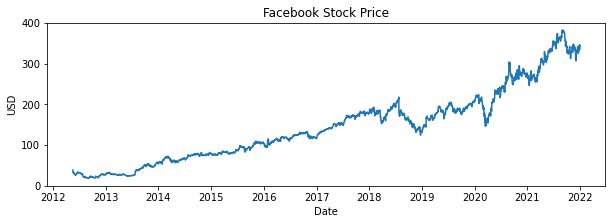

In [3]:
plotFacebookStock(data)

In [4]:
# Get technical features
technical_data = get_technical_indicators(data)
technical_data = technical_data.iloc[20:,:].reset_index(drop=True)

# Get Fourier features
fourier_data = get_fourier_transfer(technical_data)

# Get all features
data_final = pd.concat([technical_data, fourier_data], axis=1)

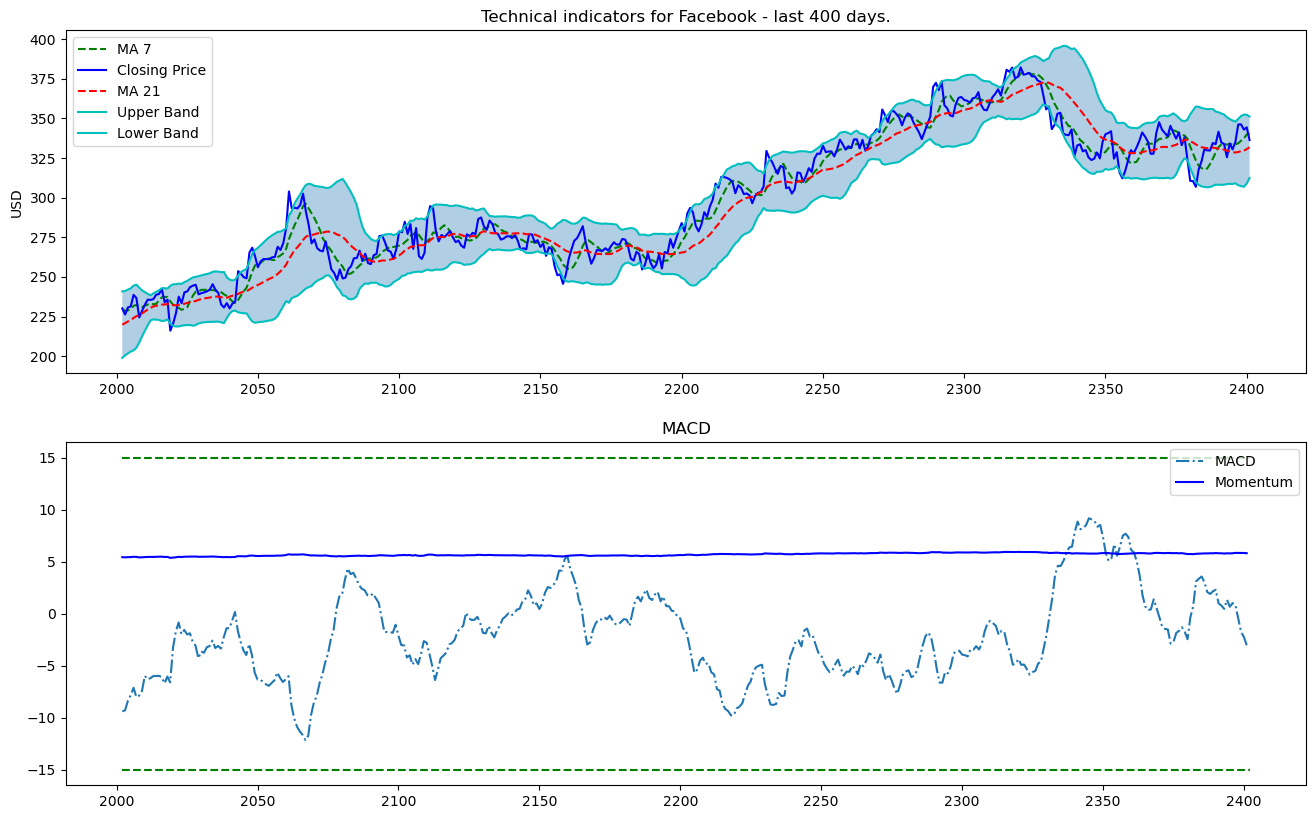

In [5]:
plot_technical_indicators(technical_data, 400)

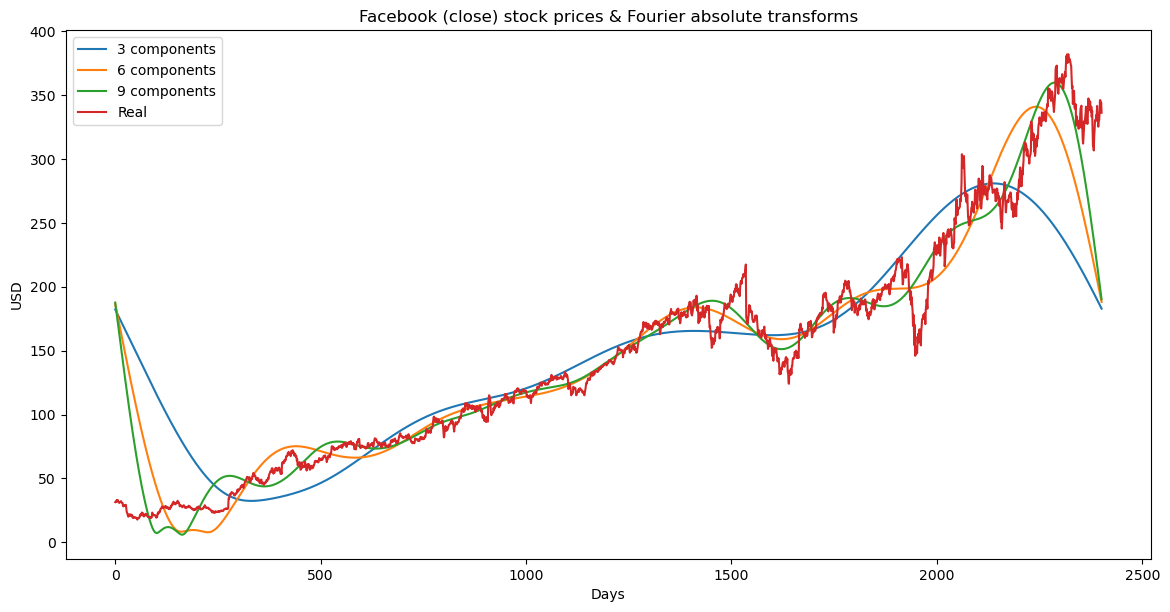

In [6]:
plot_Fourier(data_final)

In [7]:
manage_nan(data_final)
data_final = manage_dates(data_final)

In [8]:
# Get features and target
X = pd.DataFrame(data_final.iloc[:, :])
y = pd.DataFrame(data_final.iloc[:, 0])

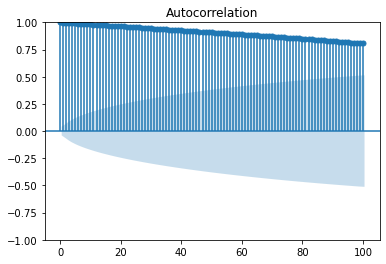

In [9]:
# Autocorrelation Check
sm.graphics.tsa.plot_acf(y.squeeze(), lags=100)
plt.show()

In [10]:
# Normalized the data
X_scaler_function = MinMaxScaler(feature_range=(-1, 1))
y_scaler_function = MinMaxScaler(feature_range=(-1, 1))

X_scaled = X_scaler_function.fit_transform(X)
y_scaled = y_scaler_function.fit_transform(y)

In [11]:
N_STEPS_IN = 3
N_STEPS_OUT = 1
pathToSave = r'Data\dataPreprocessed'
reshape_dataset(pathToSave, data_final, X_scaled, y_scaled, N_STEPS_IN, N_STEPS_OUT)

X shape:  (2399, 3, 36)
y shape:  (2399, 1)
X_train shape:  (1679, 3, 36)
y_train shape:  (1679, 1)
y_c_train shape:  (1679, 3, 1)
X_test shape:  (720, 3, 36)
y_test shape:  (720, 1)
y_c_test shape:  (720, 3, 1)
index_train shape: (1679,)
index_test shape: (720,)
Everything saved in  Data\dataPreprocessed


## Training

In [12]:
# Load data
path = r'Data\dataPreprocessed'
X_train = np.load(os.path.join(path, "X_train.npy"), allow_pickle=True)
y_train = np.load(os.path.join(path, "y_train.npy"), allow_pickle=True)
X_test = np.load(os.path.join(path, "X_test.npy"), allow_pickle=True)
y_test = np.load(os.path.join(path, "y_test.npy"), allow_pickle=True)
yc_train = np.load(os.path.join(path, "yc_train.npy"), allow_pickle=True)
yc_test = np.load(os.path.join(path, "yc_test.npy"), allow_pickle=True)

In [13]:
# Hyperparameter
EPOCHS = 100
BATCH_SIZE = 128
D_STEPS = 1
G_STEPS = 3
GP_WEIGHT = 10
D_LEARNING_RATE = 0.0001
G_LEARNING_RATE = 0.0001

In [14]:
input_generator_dim = X_train.shape[1]
feature_size = X_train.shape[2]
output_generator_dim = y_train.shape[1]

# Instantiate the optimizer for both networks
discriminator_optimizer = tf.keras.optimizers.Adam(D_LEARNING_RATE)
generator_optimizer = tf.keras.optimizers.Adam(G_LEARNING_RATE)

generator = Generator(input_generator_dim, output_generator_dim, feature_size)
generator.compile()
discriminator = Discriminator()
wgan_gp = WGAN_GP(generator, discriminator, Metric_rmse_scaled(y_scaler_function), D_STEPS, G_STEPS, GP_WEIGHT)

# Compile the WGAN model.
wgan_gp.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    d_loss_fn=discriminator_loss,
    g_loss_fn=generator_loss
)

dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train, yc_train))
dataset = dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test , y_test , yc_test ))
test_dataset = test_dataset.batch(BATCH_SIZE)

# Callback to save model
save_path = r'Models\trying'
EPOCH_MODEL_SAVE = 1

es = callbacks.EarlyStopping(monitor='val_rmse', mode='min', verbose=1, patience=20)
callback = [es, SaveModel(save_path, EPOCH_MODEL_SAVE), SaveBestModel(save_path)]

history = wgan_gp.fit(dataset, epochs=EPOCHS, callbacks=callback, validation_data=test_dataset)

Epoch 1/100
14/14 [==============================] - 28s 283ms/step - d_loss: 9.5201 - g_loss: 0.0228 - rmse: 102.9184 - val_d_loss: 9.2428 - val_g_loss: 0.0122 - val_rmse: 103.3423
Current best epoch:  1
Epoch 2/100
14/14 [==============================] - 2s 162ms/step - d_loss: 8.5765 - g_loss: 0.0641 - rmse: 48.0648 - val_d_loss: 8.8970 - val_g_loss: 0.0146 - val_rmse: 139.9245
Epoch 3/100
14/14 [==============================] - 2s 141ms/step - d_loss: 7.5287 - g_loss: 0.1162 - rmse: 64.0692 - val_d_loss: 8.4128 - val_g_loss: 0.0175 - val_rmse: 109.0643
Epoch 4/100
14/14 [==============================] - 2s 140ms/step - d_loss: 6.0882 - g_loss: 0.1898 - rmse: 72.7878 - val_d_loss: 7.6984 - val_g_loss: 0.0218 - val_rmse: 115.9449
Epoch 5/100
14/14 [==============================] - 2s 152ms/step - d_loss: 4.2099 - g_loss: 0.2996 - rmse: 75.2416 - val_d_loss: 6.9403 - val_g_loss: 0.0184 - val_rmse: 171.0306
Epoch 6/100
14/14 [==============================] - 2s 143ms/step - d_loss

14/14 [==============================] - 2s 153ms/step - d_loss: 0.0065 - g_loss: 0.7806 - rmse: 4.8938 - val_d_loss: 1.3153 - val_g_loss: -0.1994 - val_rmse: 24.5254
Epoch 46/100
14/14 [==============================] - 2s 149ms/step - d_loss: 0.0063 - g_loss: 0.7844 - rmse: 5.1972 - val_d_loss: 1.1912 - val_g_loss: -0.2043 - val_rmse: 12.6861
Epoch 47/100
14/14 [==============================] - 2s 145ms/step - d_loss: 0.0052 - g_loss: 0.7827 - rmse: 6.8537 - val_d_loss: 1.0983 - val_g_loss: -0.2080 - val_rmse: 9.3112
Current best epoch:  47
Epoch 48/100
14/14 [==============================] - 2s 144ms/step - d_loss: 0.0054 - g_loss: 0.7854 - rmse: 6.5214 - val_d_loss: 1.0238 - val_g_loss: -0.2110 - val_rmse: 12.0696
Epoch 49/100
14/14 [==============================] - 2s 156ms/step - d_loss: 0.0049 - g_loss: 0.7869 - rmse: 5.9422 - val_d_loss: 0.9718 - val_g_loss: -0.2144 - val_rmse: 19.2124
Epoch 50/100
14/14 [==============================] - 2s 142ms/step - d_loss: 0.0055 - g_l

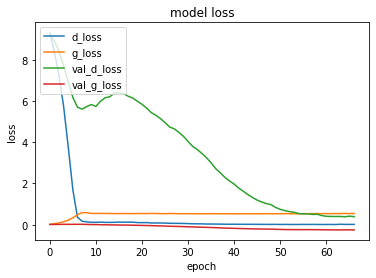

In [15]:
plot_loss(history)

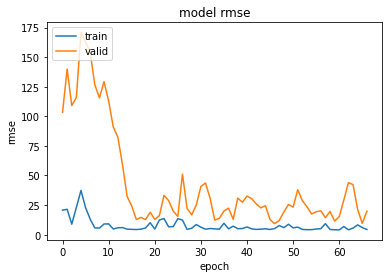

In [16]:
plot_rmse(history)

## Pred Test data

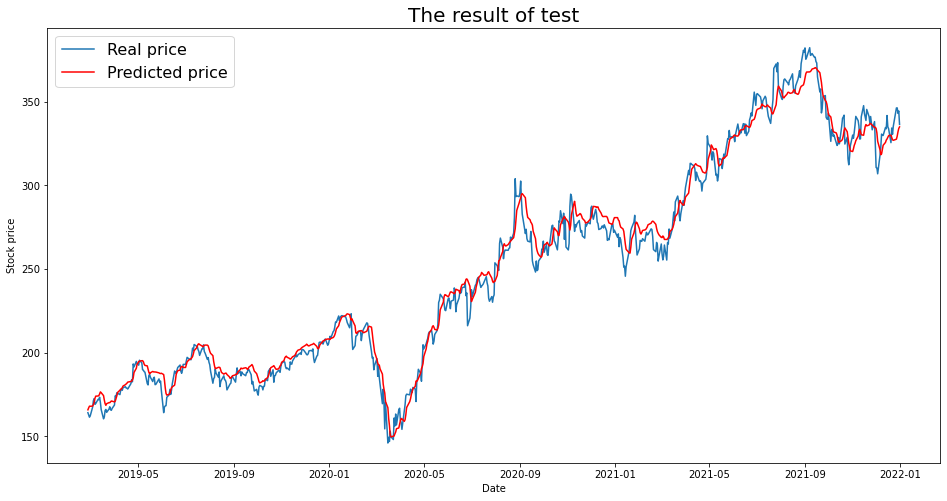

-- RMSE --  7.959552206341101


In [17]:
path = r'Data\dataPreprocessed'

# Load index
test_predict_index = np.load(os.path.join(path,"index_test.npy"), allow_pickle=True)

# Load test dataset/ model
G_model = models.load_model(r'Models\trying\wgan_gp_best.h5')
X_test = np.load(os.path.join(path,"X_test.npy"), allow_pickle=True)
y_test = np.load(os.path.join(path,"y_test.npy"), allow_pickle=True)

get_test_plot(X_test, y_test, G_model, y_scaler_function, test_predict_index)